# Recommender System

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity

In [2]:
retail = pd.read_csv('../data/retail_cluster.csv', 
                     dtype={'Customer ID': str, 'Invoice': str, 'StockCode': str})
retail.head()

,Invoice,StockCode,Quantity,Invoice DateTime,Price,Customer ID,Country,Stock Description,Amount,Invoice Date,Month,Day of Week,Hour,Recency,Frequency,Monetary,log_r,log_f,log_m,Cluster
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS,83.4,2009-12-01,12,1,7,158,8,2433.28,5.062595,2.079442,7.796995,3
1,489434,22064,24,2009-12-01 07:45:00,1.65,13085,United Kingdom,PINK DOUGHNUT TRINKET POT,39.6,2009-12-01,12,1,7,158,8,2433.28,5.062595,2.079442,7.796995,3
2,489434,21523,10,2009-12-01 07:45:00,5.95,13085,United Kingdom,DOORMAT FANCY FONT HOME SWEET HOME,59.5,2009-12-01,12,1,7,158,8,2433.28,5.062595,2.079442,7.796995,3
3,489434,79323W,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,WHITE CHERRY LIGHTS,81.0,2009-12-01,12,1,7,158,8,2433.28,5.062595,2.079442,7.796995,3
4,489434,21871,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,SAVE THE PLANET MUG,30.0,2009-12-01,12,1,7,158,8,2433.28,5.062595,2.079442,7.796995,3


In [3]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699606 entries, 0 to 699605
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Invoice            699606 non-null  object 
 1   StockCode          699606 non-null  object 
 2   Quantity           699606 non-null  int64  
 3   Invoice DateTime   699606 non-null  object 
 4   Price              699606 non-null  float64
 5   Customer ID        699606 non-null  object 
 6   Country            699606 non-null  object 
 7   Stock Description  699606 non-null  object 
 8   Amount             699606 non-null  float64
 9   Invoice Date       699606 non-null  object 
 10  Month              699606 non-null  int64  
 11  Day of Week        699606 non-null  int64  
 12  Hour               699606 non-null  int64  
 13  Recency            699606 non-null  int64  
 14  Frequency          699606 non-null  int64  
 15  Monetary           699606 non-null  float64
 16  lo

In [4]:
customer_list = pd.read_csv('../data/customer_cluster.csv', dtype={'Customer ID': str})
customer_list = customer_list[['Customer ID', 'Cluster']]
customer_list.head()

,Customer ID,Cluster
0,12346,3
1,12608,2
2,12745,2
3,12746,2
4,12747,4


In [5]:
customer_list[customer_list['Customer ID']=='12745'].iloc[0,1]

2

In [6]:
list(retail.Cluster.unique())

[3, 4, 2, 1]

In [7]:
item_list = pd.DataFrame(retail.groupby(by=['StockCode', 'Stock Description']).Invoice.count()).reset_index().iloc[:,0:2]

In [8]:
item_list[item_list.StockCode=='10109']

,StockCode,Stock Description
2,10109,BENDY COLOUR PENCILS


## User - Item Matrix

In [9]:
# create customer-item matrix
customer_item_matrix = retail.pivot_table(index='Customer ID',columns='StockCode',values='Quantity',aggfunc='sum')

In [10]:
customer_item_matrix.head()

StockCode,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,10133,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# check the shape
customer_item_matrix.shape

(5334, 4604)

In [12]:
# check the unique customer ID
retail['Customer ID'].nunique()

5334

In [13]:
# check the unique StockCode
retail['StockCode'].nunique()

4604

In [14]:
customer_item_matrix.loc['12346'].sum()

74239.0

In [15]:
retail[retail['Customer ID']=='12346']['Quantity'].sum()

74239

In [16]:
# apply lambda function to change to binary
customer_item_matrix = customer_item_matrix.applymap(lambda x: x if x>0 else 0)

In [17]:
customer_item_matrix

StockCode,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,10133,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# customer matrix
customer_item_matrix_1 = retail[retail.Cluster==1].pivot_table(index='Customer ID',columns='StockCode',values='Quantity',aggfunc='sum')
customer_item_matrix_2 = retail[retail.Cluster==2].pivot_table(index='Customer ID',columns='StockCode',values='Quantity',aggfunc='sum')
customer_item_matrix_3 = retail[retail.Cluster==3].pivot_table(index='Customer ID',columns='StockCode',values='Quantity',aggfunc='sum')
customer_item_matrix_4 = retail[retail.Cluster==4].pivot_table(index='Customer ID',columns='StockCode',values='Quantity',aggfunc='sum')

# apply lambda function to change to binary
customer_item_matrix_1 = customer_item_matrix_1.applymap(lambda x: x if x>0 else 0)
# apply lambda function to change to binary
customer_item_matrix_2 = customer_item_matrix_2.applymap(lambda x: x if x>0 else 0)
# apply lambda function to change to binary
customer_item_matrix_3 = customer_item_matrix_3.applymap(lambda x: x if x>0 else 0)
# apply lambda function to change to binary
customer_item_matrix_4 = customer_item_matrix_4.applymap(lambda x: x if x>0 else 0)

In [19]:
def user_collab_cluster(customer_id, top_n, item_df, customer_df, prt_details = 1):
    
    
    Cluster = customer_list[customer_list['Customer ID']==customer_id].iloc[0,1]  
    

    if Cluster == 1:
        customer_item_matrix = customer_item_matrix_1
        
    elif Cluster == 2:
        customer_item_matrix = customer_item_matrix_2 
        
    elif Cluster == 3:   
        customer_item_matrix = customer_item_matrix_3
        
    else: # Cluster == 4:   
        customer_item_matrix = customer_item_matrix_4
        
    user_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix))
    
    user_sim_matrix.columns = customer_item_matrix.index
    user_sim_matrix.index = customer_item_matrix.index
    
    mask = np.ones_like(user_sim_matrix)
    for i in range(len(mask)):
        for j in range(len(mask)):
            if i==j:
                mask[i,j]=0 
                
    user_sim_matrix = user_sim_matrix * mask
    items_bought_by_A = set(customer_item_matrix.loc[customer_id].iloc[customer_item_matrix.loc[customer_id].to_numpy().nonzero()].index)
    
    user_B = user_sim_matrix.loc[customer_id].sort_values(ascending = False).index[0]    
    
    if prt_details==1:
        print(f"Customer {customer_id} is from Cluster {Cluster}")
        print(f"Recommended based on Customer {user_B}")
    
    items_bought_by_B_sorted = customer_item_matrix.loc[user_B].iloc[customer_item_matrix.loc[user_B].to_numpy().nonzero()].sort_values(ascending=False)
    # recommend top 10 items
    rec_top_n = pd.DataFrame(items_bought_by_B_sorted).reset_index().iloc[:,0:1].merge(item_df, how='inner', on='StockCode')
    
    rec_top_n['Hit']=rec_top_n.StockCode.isin(items_bought_by_A) *1
    
    return rec_top_n.head(top_n)

In [22]:
# suggest top 10 itemss
user_collab_cluster('12747', 10, item_list, customer_list)

Customer 12747 is from Cluster 4
Recommended based on Customer 14440


,StockCode,Stock Description,Hit
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1
1,82494L,WOODEN FRAME ANTIQUE WHITE,1
2,82482,WOODEN PICTURE FRAME WHITE FINISH,1
3,21754,HOME BUILDING BLOCK WORD,1
4,21755,LOVE BUILDING BLOCK WORD,0
5,82486,WOOD S/3 CABINET ANT WHITE FINISH,1
6,72741,GRAND CHOCOLATECANDLE,0
7,22457,NATURAL SLATE HEART CHALKBOARD,0
8,82483,WOOD 2 DRAWER CABINET WHITE FINISH,0
9,21135,VICTORIAN METAL POSTCARD SPRING,0


In [23]:
%%time
# hit rate 

### this code will run for very long

hit_rate = []
counter = 0
max_count = len(customer_list)
for i in list(customer_list['Customer ID']):
    if counter%round(max_count*0.05)==0:
        print(f"Calculating.... {round(counter*100/max_count,2)}% done")  
    
    hit_rate.append(user_collab_cluster(i,10,item_list,customer_list,prt_details=0).Hit.mean())

    counter += 1
    
    

Calculating.... 0.0% done
Calculating.... 5.01% done
Calculating.... 10.01% done
Calculating.... 15.02% done
Calculating.... 20.02% done
Calculating.... 25.03% done
Calculating.... 30.03% done
Calculating.... 35.04% done
Calculating.... 40.04% done
Calculating.... 45.05% done
Calculating.... 50.06% done
Calculating.... 55.06% done
Calculating.... 60.07% done
Calculating.... 65.07% done
Calculating.... 70.08% done
Calculating.... 75.08% done
Calculating.... 80.09% done
Calculating.... 85.1% done
Calculating.... 90.1% done
Calculating.... 95.11% done
CPU times: total: 31min 52s
Wall time: 18min 43s


In [24]:
np.mean(hit_rate)

0.363116812779355

#### Comment:
On average, 0.3633 of the items are being bought by the customers.

In [25]:
customer_list['hit_rate'] = hit_rate

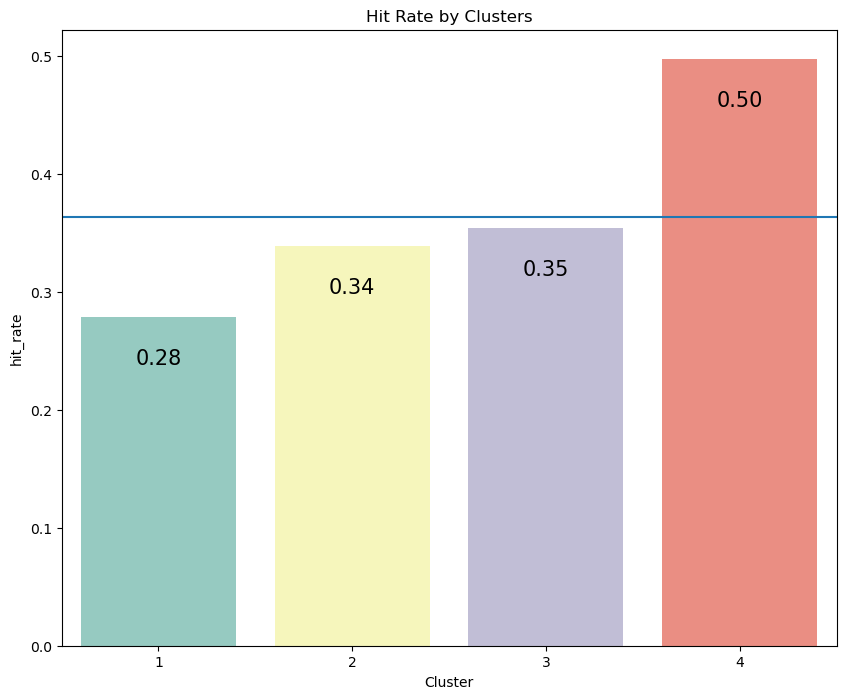

In [38]:
data = customer_list.groupby(by='Cluster').hit_rate.mean().reset_index()
plt.figure(figsize=(10,8))
ax = sns.barplot(data=data, x='Cluster', y='hit_rate', palette='Set3')
plt.title('Hit Rate by Clusters')
plt.axhline(np.mean(hit_rate))
# label each bar in histogram
for p in ax.patches:
    height = p.get_height() # get the height of each bar
    # adding text to each bar
    ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
    y = height-0.04, # y-coordinate position of data label, padded 0.2 above bar
    s = "{:.2f}".format(height), # data label, formatted to ignore decimals
    ha = 'center',
    fontsize=15) # sets horizontal alignment (ha) to center
plt.savefig("../images/hitratebyclusters.png");

## Item Based Collaborative Filtering

In [27]:
retail.groupby(by=['StockCode', 'Stock Description']).Amount.sum()

StockCode  Stock Description          
10002      INFLATABLE POLITICAL GLOBE     4847.72
10080      GROOVY CACTUS INFLATABLE        124.61
10109      BENDY COLOUR PENCILS              1.68
10120      DOGGY RUBBER                    127.26
10123C     HEARTS WRAPPING TAPE            136.04
                                           ...   
90214U     LETTER "U" BLING KEY RING         4.73
90214V     LETTER "V" BLING KEY RING        14.73
90214W     LETTER "W" BLING KEY RING         5.98
90214Y     LETTER "Y" BLING KEY RING        21.15
90214Z     LETTER "Z" BLING KEY RING         9.73
Name: Amount, Length: 4604, dtype: float64

In [28]:
item_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix.T))
item_sim_matrix.columns = customer_item_matrix.T.index
item_sim_matrix['StockCode'] = customer_item_matrix.T.index
item_sim_matrix = item_sim_matrix.set_index('StockCode')
mask = np.ones_like(item_sim_matrix)
for i in range(len(mask)):
    for j in range(len(mask)):
        if i==j:
            mask[i,j]=0 
item_sim_matrix = item_sim_matrix * mask
#customer_item_matrix
#item_sim_matrix

In [29]:
def item_collab(item_sim_matrix, top_n, item_id, item_list, prt_statement = 1):
    top_n_similar_items = item_sim_matrix.loc[item_id].sort_values(ascending=False).iloc[:top_n].index
    if prt_statement==1:
        print(f"Recommender for Item {item_id} - {item_list[['Stock Description']][item_list.StockCode==item_id].iloc[0,0]}")
    rec_item = pd.DataFrame(top_n_similar_items).merge(item_list,how='inner',on='StockCode')
    return rec_item

In [30]:
retail.groupby(['StockCode','Stock Description'])['Invoice'].count().sort_values(ascending=False)

StockCode  Stock Description                 
85123A     WHITE HANGING HEART T-LIGHT HOLDER    4834
85099B     JUMBO BAG RED RETROSPOT               3020
22423      REGENCY CAKESTAND 3 TIER              2871
84879      ASSORTED COLOUR BIRD ORNAMENT         2544
20725      LUNCH BAG RED RETROSPOT               2314
                                                 ... 
90135      ORANGE/WHT/FUSCHIA STONES NECKLACE       1
90135A     ORANGE/FUSCHIA STONES NECKLACE           1
37408      ASSORTED DESIGN GEISHA GIRL MUGS         1
37379B     BLUE CHERRY BLOSSOM CUP & SAUCER         1
20791      BLUE TILED SET OF 3 DRAWERS              1
Name: Invoice, Length: 4604, dtype: int64

In [31]:
rec_items = item_collab(item_sim_matrix, 10, '10109', item_list)
rec_items

Recommender for Item 10109 - BENDY COLOUR PENCILS


,StockCode,Stock Description
0,16215,FUNKY GIRLZ MAGNETIC TO DO LIST
1,16245A,PINK MINI STATIONERY SET W CASE
2,81953B,ROUND BLUE CLOCK WITH SUCKER
3,81953P,ROUND ARTICULATED PINK CLOCK W/SUCK
4,23185,FRENCH STYLE STORAGE JAR JAM
5,84455,SET OF 3 RABBIT CARROTS EASTER
6,47552A,DOTS IRONING BOARD COVER
7,84925C,FAIRY CAKES WALL THERMOMETER
8,84340,LARGE FIBRE OPTIC CHRISTMAS TREE
9,20673,STRAWBERRIES PRINT BOWL


In [32]:
invoice_item_matrix = retail.pivot_table(index='Invoice',columns='StockCode',values='Quantity',aggfunc='sum')

# apply lambda function to change to binary
invoice_item_matrix = invoice_item_matrix.applymap(lambda x: 1 if x>0 else 0)
invoice_item_matrix.head()

StockCode,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,10133,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489437,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
invoice_check = invoice_item_matrix.loc[:,rec_items.StockCode]
invoice_check['number_hits'] = invoice_check.sum(axis=1)
invoice_check['hit_true_false'] = invoice_check.number_hits.apply(lambda x: 1 if x>0 else 0)
invoice_check[invoice_check.hit_true_false==1]

StockCode,16215,16245A,81953B,81953P,23185,84455,47552A,84925C,84340,20673,number_hits,hit_true_false
Invoice,,,,,,,,,,,,
489529,0,0,0,0,0,0,0,0,0,1,1,1
489573,0,0,0,0,0,0,0,0,1,0,1,1
489791,0,0,0,0,0,0,0,1,0,0,1,1
489875,0,0,0,0,0,0,0,0,1,0,1,1
490002,1,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
576861,0,0,0,0,1,0,0,0,0,0,1,1
577297,0,0,0,0,1,0,0,0,0,0,1,1
577733,0,0,0,0,1,0,0,0,0,0,1,1


In [34]:
invoice_check.hit_true_false.mean()

0.0026078354965378735

In [37]:
item_list.head(10)

,StockCode,Stock Description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10109,BENDY COLOUR PENCILS
3,10120,DOGGY RUBBER
4,10123C,HEARTS WRAPPING TAPE
5,10123G,ARMY CAMO WRAPPING TAPE
6,10124A,SPOTS ON RED BOOKCOVER TAPE
7,10124G,ARMY CAMO BOOKCOVER TAPE
8,10125,MINI FUNKY DESIGN TAPES
9,10133,COLOURING PENCILS BROWN TUBE


In [36]:
# hit rate 

### this code will run for very long

hit_rate_item = []
counter = 0
max_count = len(item_list)
for i in list(item_list['StockCode']):
    if counter%round(max_count*0.05)==0:
        print(f"Calculating.... {round(counter*100/max_count,2)}% done")  
    
    rec_items = item_collab(item_sim_matrix, 10, i, item_list,prt_statement=0)
    invoice_check = invoice_item_matrix.loc[:,rec_items.StockCode]
    invoice_check['number_hits'] = invoice_check.sum(axis=1)
    invoice_check['hit_true_false'] = invoice_check.number_hits.apply(lambda x: 1 if x>0 else 0)
    hit_rate_item.append(invoice_check.hit_true_false.mean())
    
    counter += 1
    
print('Done')

Calculating.... 0.0% done
Calculating.... 5.0% done
Calculating.... 9.99% done
Calculating.... 14.99% done
Calculating.... 19.98% done
Calculating.... 24.98% done
Calculating.... 29.97% done
Calculating.... 34.97% done
Calculating.... 39.97% done
Calculating.... 44.96% done
Calculating.... 49.96% done
Calculating.... 54.95% done
Calculating.... 59.95% done
Calculating.... 64.94% done
Calculating.... 69.94% done
Calculating.... 74.93% done
Calculating.... 79.93% done
Calculating.... 84.93% done
Calculating.... 89.92% done
Calculating.... 94.92% done
Calculating.... 99.91% done
Done
